<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_cnn1d_dna_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras 1D Convolutional Neural Net for DNA Transcription Prediction

In this notebook we walk through the use of a 1D convolutional neural network to make predictions about DNA sequences. We utilize an example from Chapter 6 of the book Deep Learning for Genomics by Ramsundar et al (OReilly).

The example covered in Chapter 6 is the problem of predicting where in a sequence of DNA the RNA transcriptase will bind to DNA and begin the transcription process. The data set consists of DNA (a 1-dimensional sequence of characters from a 4-letter alphabet) and a binary label - is this sequence a transcription factor binding site or not. 

From a deep learning perspective, the problem is interesting for a number of reasons:

* Convolutional neural networks are commonly-used deep learning architecture
* Dealing with 1D data is useful
* Requires turning DNA sequences into data that can be fed to a deep learning model

## Imports

Here are the import statements:

In [0]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For loading data sets
import joblib

# Useful sklearn metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [0]:
seed = 1729
np.random.seed(seed)

In [2]:
import keras

from keras import metrics

from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import LeakyReLU

Using TensorFlow backend.


In [0]:
# Make sure we're using the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Transcription Factor Example



## Overview

This example will use a data set about a [transcription factor called JunD](https://www.uniprot.org/uniprot/P17535). 

The data set used in this example comes from the human chromosome 22 (the smallest human chromosome). It is 50 Mbp.

The chromosome is broken into short segments of 101 base pairs.

One hot encoding is used to represent the sequences (i.e., each base pair is turned into a vector of 0s and 1s).

In [4]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

Cloning into 'DeepLearningLifeSciences'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 24), reused 85 (delta 17), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

## 1D Convolutional Neural Networks

Beacuse we are dealing with a 1D sequence of data, we use a convolutional neural network (CNN) that performs the convolution in 1 dimension (1D CNN).

(A 2D convolutional neural network would be good for spatial or image data, while a 3D convolutional neural network would be good for volumetric data.)

Typically, 1D convolutional neural networks have the following layers:

* Convolution layer, or (for 2D CNN) multiple convolution layers followed by a pooling layer

* Dropout layer (optional)

* Flatten layer (all output becomes 1D)

* Dense layer (everything-connected-to-everything network; number of dense output neurons = number of classes)

**Strategy:** We start by implementing a 1D CNN using the architecture in Chapter 6 of <u>Deep Learning for the Life Sciences</u>. We then implement another 1D CNN model using an example from the [Keras documentation](https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions) for sequence classification using Keras. It uses a different sequence of layers.

## Load Data

Before we get to the CNN layers, we start by loading the data, bypassing the `DiskDataset` provided by DeepChem and loading the data set directly into memory with `joblib`.

**NOTE:** If the data set were actually large enough to require it to be on disk we would need to use a generator function. We illustrate how to do that below.

In [0]:
def load_dataset(which_dataset):
    import os
    
    if which_dataset not in ['train','valid','test']:
        raise Exception("Error: can only load datasets 'train', 'valid', or 'test', you specified %s"%(which_dataset))
    
    # Set data directory name
    data_dir = "%s_dataset"%(which_dataset)
    
    # Set filenames for X, y, w, labels
    base_filename = "shard-0-%s.joblib"
    X_filename    = os.path.join(data_dir,base_filename%("X"))
    y_filename    = os.path.join(data_dir,base_filename%("y"))
    w_filename    = os.path.join(data_dir,base_filename%("w"))
    ids_filename  = os.path.join(data_dir,base_filename%("ids"))
    
    X = joblib.load(X_filename)
    y = joblib.load(y_filename)
    w = joblib.load(w_filename)
    ids = joblib.load(ids_filename)
    
    return X, y, w, ids

In [7]:
train = load_dataset('train')
valid = load_dataset('valid')
test = load_dataset('test')

X_train, y_train, w_train, ids_train = load_dataset('train')
X_valid, y_valid, w_valid, ids_valid = load_dataset('valid')
X_test, y_test, w_test, ids_test = load_dataset('test')

n_train_obs = np.shape(X_train)[0]
n_valid_obs = np.shape(X_valid)[0]
n_test_obs = np.shape(X_test)[0]

w_train = np.squeeze(w_train)
w_valid = np.squeeze(w_valid)
w_test = np.squeeze(w_test)

print('-'*20)
print('training data shape:')
print(np.shape(X_train))
print(np.shape(y_train))
print('-'*20)
print('validation data shape:')
print(np.shape(X_valid))
print(np.shape(y_valid))
print('-'*20)
print('test data shape:')
print(np.shape(X_test))
print(np.shape(y_test))

--------------------
training data shape:
(276216, 101, 4)
(276216, 1)
--------------------
validation data shape:
(34527, 101, 4)
(34527, 1)
--------------------
test data shape:
(34528, 101, 4)
(34528, 1)


The $y$ vector contains the binary output 0 or 1.

The authors of the book have provided the data - the 0s and 1s of the y vector - as 64-bit integers. They probably could have used 8-bit integers and saved some space. Someone should submit a pull request to [deepchem/DeepLearningLifeSciences](https://github.com/deepchem/DeepLearningLifeSciences).

In [8]:
print(type(y_test[0][0]))

<class 'numpy.int64'>


In [9]:
print(np.unique(y_test))

[0 1]


Also important to note - the data set is very skewed toward one class (the negative class):

In [10]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))
print(np.sum(y_train==1)/np.sum(y_train==0))

275048
1168
0.004246531514499287


In [11]:
print(np.sum(y_test==0))
print(np.sum(y_test==1))
print(np.sum(y_test==1)/np.sum(y_test==0))

34382
146
0.004246408004188238


### CNN Architecture

The layers of the DeepChem Chapter 6 example network are as follows:

* Conv1D layer
* Dropout layer
* Conv1D layer
* Dropout layer
* Conv1D layer
* Dropout layer
* Flatten layer
* Dense layer (1 perceptron)

As before, the last layer has a single perceptron that outputs the 0 or 1 binary classification prediction.

(Also note, number of filters is typically a power of 2, so rather than using the book's 15 channels we have used 16 channels.)

A few Keras documentation links helpful for translating from Keras to DeepChem:
* [Conv1D layer](https://keras.io/layers/convolutional/)
* [MaxPooling1D layer](https://keras.io/layers/pooling/)



Side note: before defining the convolutional neural net, we should define a few metrics we are interested in first. We utilize two metrics, the accuracy and the F-value, defined as follows:

$$
\mbox{Accuracy} = \dfrac{\mbox{TP} + \mbox{TN}}{\mbox{TP} + \mbox{FP} + \mbox{TN} + \mbox{FN}}
$$

$$
\mbox{Precision} = \dfrac{ \mbox{TP} }{ \mbox{TP} + \mbox{FP} }
$$

$$
\mbox{Recall} = \dfrac{ \mbox{TP} }{ \mbox{TP} + \mbox{FN} }
$$

$$
\mbox{F-value} = \dfrac{ 2 \mbox{Recall} \times \mbox{Precision} }{ \mbox{Recall} + \mbox{Precision} }
$$

**Accuracy:** We expect the accuracy to be extremely high - accuracy takes into account both correct positive guesses and correct negative guesses, and any classifier could achieve high accuracy by simply guessing 0 all the time.

**Precision:** We are more interested in the precision than accuracy, as it defines a metric that focuses only on the positive classification task. We expect this to be a better measure of the model's accuracy. (Also note the ROC curve plots TP vs FP so the ROC curve can be thought of as a graphical representation of the precision.) This is a measure of how well the model did _when it guessed positive_.

**Recall:** Recall accounts for false negatives as well as true positives - that is, examples that should have been labeled positive but were missed by the model. This is a measure of how well the model did _on all the positive examples_.

**F-value:** This measure is the _harmonic mean_ of precision and recall. Because recall increases as the model guesses less conservatively, and precision increases as it guesses more conservatively, there must be a tradeoff. The F-value is the harmonic mean of the two. Recall and precision will always be bounded from 0 to 1. Here is a contour plot of the harmonic mean function $f(x,y) = \dfrac{2xy}{x+y}$ on the unit square:

![contour of z = (2xy)/(x+y)](https://raw.githubusercontent.com/charlesreid1/dib-deep-chem/master/img/contour.png)

A higher F score indicates an optimum tradeoff between recall (not making the positive call when you should) and precision (being correct when you make the positive call).

Custom Keras metrics can be defined and will be computed at the end of each epoch. A metric is just a function that takes two arguments - the true $y$ values, and the predicted $y$ values. Accuracy is already built in to Keras. We define precision, recall, and F-value below.

(Note that we define these as functions and use them as metrics, but they could also be implemented as [Callback objects](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2) that have an initialization method `on_train_begin()` and a method run at the end of each epoch, `on_epoch_end()`).

## Definitions of Custom Keras Metrics

To compute metrics at each epoch (i.e., at the end of each training iteration), we define a function that takes a vector of true values and a vector of predicted values, and use those to compute and return the mtetric.

In [0]:
# via https://github.com/keras-team/keras/issues/6507#issuecomment-322857357

import keras.backend as K

def precision(y_true, y_pred):
    # Calculate the precision
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fvalue(y_true, y_pred):
    # Calculate the F-value
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true,y_pred)
    r = recall(y_true,y_pred)
    fvalue = (2 * p * r)/(p + r + K.epsilon())
    return fvalue


Now we can pass those function handles to the `model.compile()` call (see last line below):

In [13]:
features = 4
seq_length = 101
convolution_window = 10
n_filters = 16

model = Sequential()

# Unroll the book's for loop

# Convolution layer 1
model.add(Conv1D(n_filters, convolution_window, 
                 activation='relu', padding='same', 
                 input_shape=(seq_length, features)))

model.add(Dropout(0.5))

# Convolution layer 2
model.add(Conv1D(n_filters, convolution_window, 
                 activation='relu', padding='same'))

model.add(Dropout(0.5))

# Convolution layer 3
model.add(Conv1D(n_filters, convolution_window, 
                 activation='relu', padding='same'))

model.add(Dropout(0.5))

# Flatten to 1D
model.add(Flatten())

# Shrink to 1 neuron for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              sample_weight_mode=None,
              metrics=['accuracy',
                       precision,
                       recall,
                       fvalue])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Side Note:** as per [this Keras issue](https://github.com/keras-team/keras/issues/3230), the ROC AUC cannot be implemented directly as a metric by Keras because (1) it is a global metric and can therefore be misleading to use as a metric to monitor during iterations, and (2) for keras to use it as a loss function (use it as the objective function) it must be differentiable.

We show how to plot the ROC curve in post-processing below.

(Note: [useful issue/thread on sample weights](https://github.com/keras-team/keras/issues/3653) in the keras repo. It was important to _both_ use the "adam" optimizer _and_ set the sample weights as below.)

Now train the model:

In [14]:
# Train the model, then evaluate/save the ROC curve
num_epochs = 50
hist = model.fit(X_train, y_train,
                 sample_weight = w_train,
                 batch_size=1000, 
                 epochs=num_epochs,
                 verbose = 1,
                 validation_data=(X_valid, y_valid, w_valid))

Instructions for updating:
Use tf.cast instead.
Train on 276216 samples, validate on 34527 samples
Epoch 1/50
276216/276216 [==============================] - 8s 29us/step - loss: 0.6992 - acc: 0.5451 - precision: 0.0042 - recall: 0.4365 - fvalue: 0.0083 - val_loss: 0.6931 - val_acc: 0.1265 - val_precision: 0.0043 - val_recall: 0.8618 - val_fvalue: 0.0085
Epoch 2/50
276216/276216 [==============================] - 3s 11us/step - loss: 0.6939 - acc: 0.4716 - precision: 0.0044 - recall: 0.5508 - fvalue: 0.0087 - val_loss: 0.6925 - val_acc: 0.5135 - val_precision: 0.0046 - val_recall: 0.5332 - val_fvalue: 0.0091
Epoch 3/50
276216/276216 [==============================] - 3s 11us/step - loss: 0.6942 - acc: 0.5170 - precision: 0.0044 - recall: 0.4914 - fvalue: 0.0087 - val_loss: 0.6929 - val_acc: 0.2163 - val_precision: 0.0044 - val_recall: 0.8031 - val_fvalue: 0.0087
Epoch 4/50
276216/276216 [==============================] - 3s 11us/step - loss: 0.6933 - acc: 0.5003 - precision: 0.0045 - 

Visualization of the loss function and metrics:

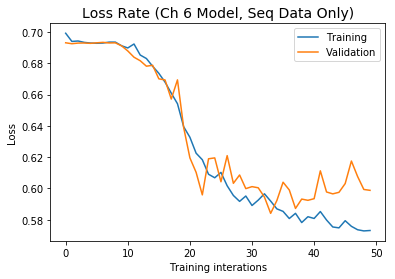

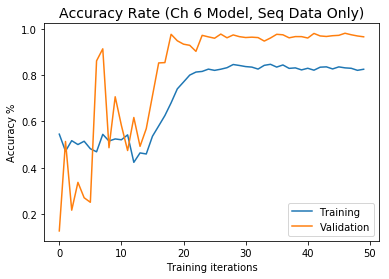

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Rate (Ch 6 Model, Seq Data Only)', size=14)
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy Rate (Ch 6 Model, Seq Data Only)', size=14)
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()

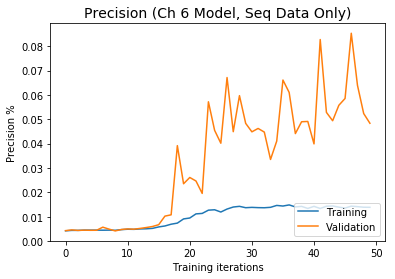

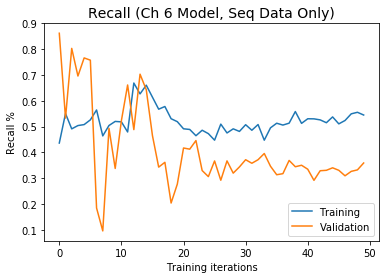

In [16]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('Precision (Ch 6 Model, Seq Data Only)', size=14)
plt.ylabel('Precision %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()

plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('Recall (Ch 6 Model, Seq Data Only)', size=14)
plt.ylabel('Recall %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


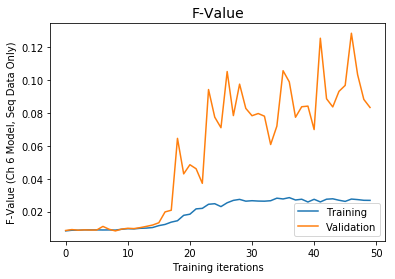

In [17]:
plt.plot(hist.history['fvalue'])
plt.plot(hist.history['val_fvalue'])
plt.title('F-Value', size=14)
plt.ylabel('F-Value (Ch 6 Model, Seq Data Only)')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


Now we can visualize the performance of the binary classification task using the ROC (receiver operating characteristic) curve, which shows true positives versus false positives - focusing on the O(100) positive instances, rather than all 30,000+ data points. The closer to x = y the curve gets, the worse it performs. Ideally we have a large area under the curve.

The sklearn package has the ROC curve as a built-in metric:

No handles with labels found to put in legend.


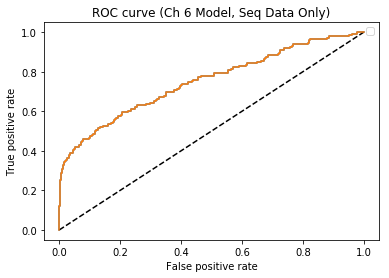

In [18]:
# Useful function for plotting the ROC curve
from sklearn.metrics import roc_curve

# Get model predictions on test data
y_model = model.predict(X_test).ravel()

# Form the ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_model)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC curve (Ch 6 Model, Seq Data Only)')
plt.legend(loc='best')
plt.show()

If we call the `evaluate()` method on the model, it returns the loss value and metrics values for the model in test mode.

Here are the loss value and accuracy for our model run on the test data:

In [19]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Loss value: %0.4f"%(scores[0]))
print("Accuracy: %0.4f"%(scores[1]))
print("Precision: %0.4f"%(scores[2]))
print("Recall: %0.4f"%(scores[3]))
print("F-Value: %0.4f"%(scores[4]))

Loss value: 0.4588
Accuracy: 0.9692
Precision: 0.0361
Recall: 0.0473
F-Value: 0.0390


We can also plot the confusion matrix to get a sense of how well our model is doing:

In [20]:
# True values: y_test
# Pred values: y_model
cm = confusion_matrix(y_test, np.round(y_model))
print(cm)

[[33410   972]
 [   93    53]]


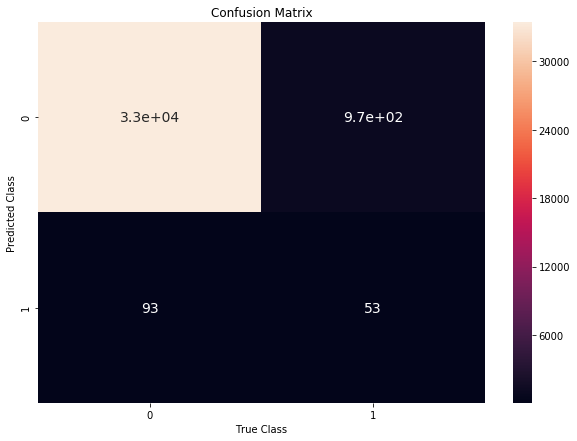

In [21]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,annot_kws={"size": 14})
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix")
plt.show()

We can also look at the distribution of outputs from the model, which are between 0 and 1 (we round them to get the guessed class):

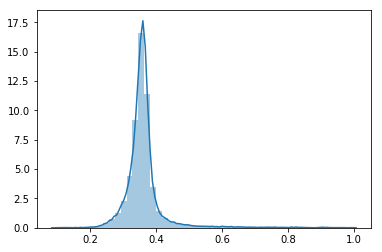

In [22]:
sns.distplot(y_model)

# Using the Keras Example 1D CNN

The convolutional neural network proposed in Chapter 6 does not match the 1D convolutional neural net example contained in the Keras documentation [here](https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions), so before we move on to adding chromatin data, we try the Keras architecture, and see if there is a significant difference in performance.

**NOTE:** The main difference between the Keras 1D CNN and the Chapter 6 1D CNN is, the Chapter 6 1D CNN uses more dropout layers to prevent overfitting.

In [0]:
features = 4
seq_length = 101
convolution_window = 10
n_filters = 15

model2 = Sequential()

model2.add(Conv1D(n_filters, convolution_window,
                  activation='relu', padding='same',
                  input_shape=(seq_length, features)))

model2.add(Conv1D(n_filters, convolution_window,
                  activation='relu', padding='same'))

model2.add(MaxPooling1D(3))

model2.add(Conv1D(2*n_filters, convolution_window,
                  activation='relu', padding='same'))

model2.add(Conv1D(2*n_filters, convolution_window,
                  activation='relu', padding='same'))

model2.add(GlobalAveragePooling1D())

model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
               sample_weight_mode=None,
               optimizer='adam',
               metrics=['accuracy',
                        precision,
                        recall,
                        fvalue])

Now fit the model to data as before:

In [24]:
# Train the model,
# then evaluate/save the ROC curve
num_epochs = 50
hist2 = model2.fit(X_train, y_train,
                   sample_weight = w_train,
                   batch_size=1000, 
                   epochs=num_epochs,
                   verbose = 1,
                   validation_data=(X_valid, y_valid, w_valid))

Train on 276216 samples, validate on 34527 samples
Epoch 1/50
276216/276216 [==============================] - 5s 17us/step - loss: 0.6936 - acc: 0.4727 - precision: 0.0044 - recall: 0.5219 - fvalue: 0.0086 - val_loss: 0.6931 - val_acc: 0.0240 - val_precision: 0.0043 - val_recall: 0.9652 - val_fvalue: 0.0085
Epoch 2/50
276216/276216 [==============================] - 3s 9us/step - loss: 0.6935 - acc: 0.3645 - precision: 0.0044 - recall: 0.6522 - fvalue: 0.0087 - val_loss: 0.6964 - val_acc: 0.9958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_fvalue: 0.0000e+00
Epoch 3/50
276216/276216 [==============================] - 3s 9us/step - loss: 0.6925 - acc: 0.6215 - precision: 0.0038 - recall: 0.3891 - fvalue: 0.0073 - val_loss: 0.6924 - val_acc: 0.0241 - val_precision: 0.0043 - val_recall: 0.9662 - val_fvalue: 0.0085
Epoch 4/50
276216/276216 [==============================] - 3s 9us/step - loss: 0.6919 - acc: 0.2964 - precision: 0.0050 - recall: 0.7517 - fvalue: 0.0098 - val_l

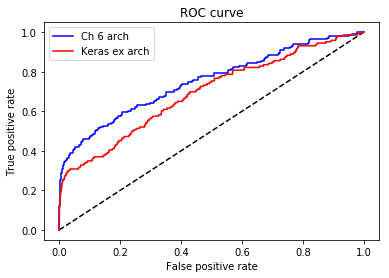

In [25]:
y_model1 = model.predict(X_test).ravel()
fpr1, tpr1, _ = roc_curve(y_test, y_model1)

y_model2 = model2.predict(X_test).ravel()
fpr2, tpr2, _ = roc_curve(y_test, y_model2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Ch 6 arch', color='b')
plt.plot(fpr2, tpr2, label='Keras ex arch', color='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

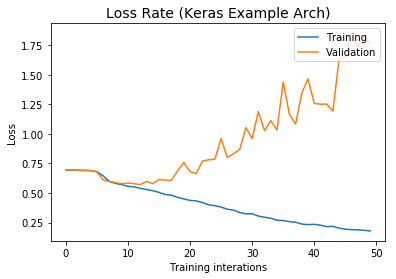

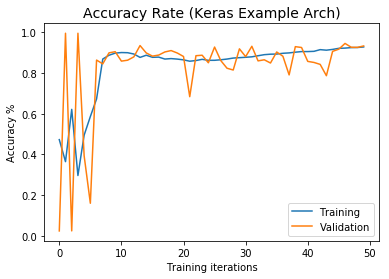

In [26]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Loss Rate (Keras Example Arch)', size=14)
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('Accuracy Rate (Keras Example Arch)', size=14)
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


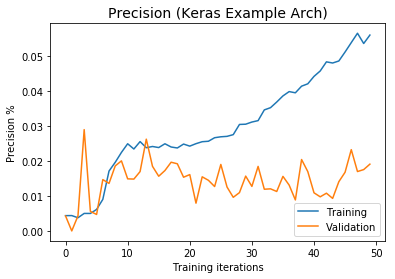

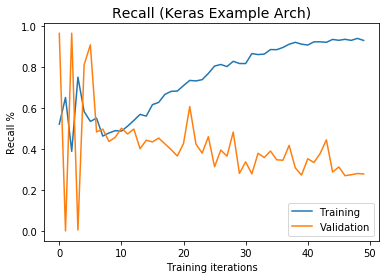

In [27]:
plt.plot(hist2.history['precision'])
plt.plot(hist2.history['val_precision'])
plt.title('Precision (Keras Example Arch)', size=14)
plt.ylabel('Precision %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()

plt.plot(hist2.history['recall'])
plt.plot(hist2.history['val_recall'])
plt.title('Recall (Keras Example Arch)', size=14)
plt.ylabel('Recall %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


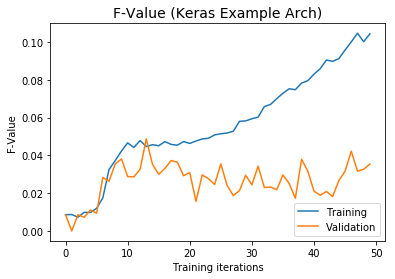

In [28]:
plt.plot(hist2.history['fvalue'])
plt.plot(hist2.history['val_fvalue'])
plt.title('F-Value (Keras Example Arch)', size=14)
plt.ylabel('F-Value')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


In [29]:
# True values: y_test
# Pred values: y_chmodel
cm2 = confusion_matrix(y_test, np.round(y_model2))
print(cm2)

[[32201  2181]
 [  100    46]]


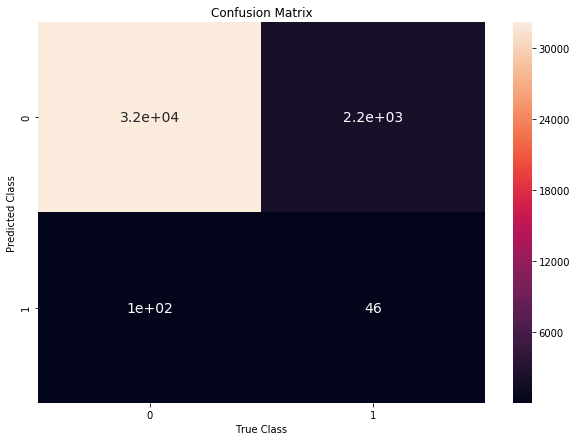

In [30]:
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot=True,annot_kws={"size": 14})
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix")
plt.show()

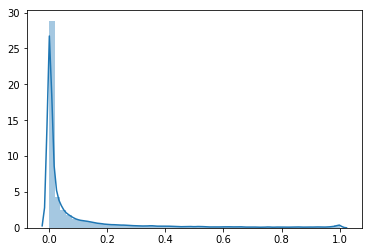

In [31]:
sns.distplot(y_model2)

In [32]:
print(np.max(y_model2))

1.0


# Adding Chromatin Accessibility Data

The poor performance of the sequential model is no reason to give up. Rather than fiddling with the layers and parameters, we should start by adding more data to the model.

Towards this end, we provide the model with additional data about availability of chromatin for each sequence. This requires making modifications to the neural network so it can take multiple inputs.

In [33]:
!ls DeepLearningLifeSciences/Chapter06/

chromatin.txt  tfbinding_chromatin.py  train_siRNA
rnai.py        tfbinding.py	       valid_dataset
test_dataset   train_dataset	       valid_siRNA


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In [0]:
span_accessibility = {}
for line in open('chromatin.txt','r'):
    fields = line.split()
    span_accessibility[fields[0]] = float(fields[1])

In [0]:
def get_accessibility_data():
    """Load the chromatin accessibility data
    and return it as a Python dictionary indexed
    by sequence IDs.
    """
    # Load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    return accessibility

Now we need to add an additional input layer into the model. The book does this by adding one feature layer with one feature (the chromatin accessibility value), then concatenating the input to the final Flatten layer.

We build a new chromatin model with the book's architecture. However, this time we build the model differently: we use the Keras functional API (where layers are called as functions, with the prior layer passed as arguments). This allows us to create a layer that concatenates multiple inputs.

In [0]:
features = 4
seq_length = 101
convolution_window = 10
n_filters = 15

# The following creates a model using the Keras functional API
# (instead of using Sequential() and adding layers one at a time)

# Sequence portion of the neural net
sequence_input = Input(shape=(seq_length,features))


# Layers for sequential data
# 
# Layer 1
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', padding='same')(sequence_input)
seq = Dropout(0.5)(seq)

# Layer 2
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', padding='same')(seq)
seq = Dropout(0.5)(seq)

# Layer 3
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', padding='same')(seq)
seq = Dropout(0.5)(seq)

# Flatten to 1D
seq = Flatten()(seq)

# Assemble the sequential network
seq = keras.Model(inputs=sequence_input, outputs=seq)

# Layer for chromatin input
chromatin_input = Input(shape=(1,))

# Create a concatenation layer
# that combines the output of the 
# 1D CNN with the chromatin coverage value
fin = keras.layers.concatenate([seq.output,chromatin_input])

fin = Dense(1,activation='sigmoid')(fin)

chromatin_model = keras.Model(inputs=[seq.input,chromatin_input], outputs=fin)

# Now compile the model
chromatin_model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        sample_weight_mode=None,
                        metrics=['accuracy',
                                 precision,
                                 recall,
                                 fvalue])

Now our `chromatin_model` takes two inputs: one is our sequential input (as before), the other is the chromatin accessibility data.

### Keras Data Generator

In the DeepChem book, the custom `DiskDataset` class provided by DeepChem has a built-in method to iterate through the data in batches. Because we've switched to Keras, we have extra work to do to implement our own data generator function.

The sequence data generator can take any input arguments; each time it is called it should return a batch of data. When we fit our model to data, we should use the model function `fit_generator()` instead of `fit()`.

Hat tip to a [pyimagesearch blog post](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/) on this topic!

Also note, as per [this comment](https://github.com/keras-team/keras/issues/3653#issuecomment-426724197) in an issue in the keras repo, if the model is expecting weights, the generator should return weights as the last item in the tuple returned.

In [0]:
# A generator function that generates
# batches of input (sequence-plus-chromatin)
# and output (0/1 labels) data

def sequence_data_generator(mode, dataset, batch_size):
    """Generator function that returns one batch of data per call.
    The neural net model takes two inputs, so this should
    return a tuple, with the first input (one-hot encoded DNA 
    sequence) as the first item and the second input (chromatin
    accessibility) as the second item.
    
    Args:
        mode               String indicating generator mode
                           ("train" loops infinitely, "eval" stops at end)
        dataset            Which data set to load
                           ("train", "valid", "test")
        batch_size         Size of batch data returned
    """
    if mode not in ["train","eval"]:
        raise Exception("Invalid mode specified: must be 'train' or 'eval'")
    if dataset not in ["train","valid","test"]:
        raise Exception("Invalid dataset specified: must be 'train', 'valid', 'test'")
    
    # Because our data set is small enough,
    # we start by loading everything into
    # memory, and loop over it to return batches.
    data_dir = "%s_dataset"%(dataset)
    base_filename = "shard-0-%s.joblib"
    
    # Load sequence data
    X   = joblib.load(os.path.join(data_dir, base_filename%("X")))
    y   = joblib.load(os.path.join(data_dir, base_filename%("y")))
    w   = joblib.load(os.path.join(data_dir, base_filename%("w")))
    ids = joblib.load(os.path.join(data_dir, base_filename%("ids")))
    
    w = np.squeeze(w)
    
    # Load chromatin accessibility data
    accessibility = get_accessibility_data()
    
    # Convert to numpy array
    chrom_accessibility = np.array([accessibility[k] for k in ids])
        
    # Get some useful numbers
    n_obs     = np.shape(X)[0]
    n_batches = math.ceil(n_obs/batch_size)
    if batch_size > n_obs:
        raise Exception("Invalid batch_size specified: larger than data set!")
    

    # Sequence data generators for keras 
    # should be infinite for training mode
    # and should stop for evaluation mode
    
    batch_start = 0
    batch_end = batch_start + batch_size
    
    # To assemble the batch:
    # - get the X and y values corresponding to these observations
    # - get the sequence IDs corresponding to observations
    # - convert the sequence IDs to a chromatin accessibility vector
    X_batch = X[batch_start:batch_end]
    y_batch = y[batch_start:batch_end]
    w_batch = w[batch_start:batch_end]
    ids_batch = ids[batch_start:batch_end]
    acc_batch = np.array([accessibility[k] for k in ids_batch])
    yield ([X_batch,acc_batch], y_batch, w_batch)
    
    while True:
        
        # Update indices
        batch_start = batch_end
        batch_end = batch_start + batch_size
        
        # Left and right halves of batch (X and chromatin access)
        X_batch = None
        y_batch = None
        w_batch = None
        ids_batch = None
        acc_batch = None
        
        if batch_end < n_obs:
            
            # Not at the end of the data set yet
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            w_batch = w[batch_start:batch_end]
            ids_batch = ids[batch_start:batch_end]
            acc_batch = np.array([accessibility[k] for k in ids_batch])
            
        else:
            
            # Reached end of data set
            if mode=="train":
                # Loop back around forever
                batch_end = batch_end%n_obs
                sss = X[batch_start:]
                eee = X[:batch_end]
                X_batch   = np.concatenate([X[batch_start:],X[:batch_end]])
                y_batch   = np.concatenate([y[batch_start:],y[:batch_end]])
                w_batch   = np.concatenate([w[batch_start:],w[:batch_end]])
                ids_batch = np.concatenate([ids[batch_start:], ids[:batch_end]])
                acc_batch = np.array([accessibility[k] for k in ids_batch])
                
            elif mode=="eval":
                # Reset counter
                batch_end = 0
                # Stop short at the end
                X_batch   = X[batch_start:]
                y_batch   = y[batch_start:]
                w_batch   = y[batch_start:]
                ids_batch = ids[batch_start:]
                acc_batch = np.array([accessibility[k] for k in ids_batch])

        # Return a list of two inputs (to match the neural net architecture)
        # and one output, glued together in a tuple
        yield ([X_batch,acc_batch],y_batch,w_batch)


In [0]:
batch_size = 1000

# We already know the size of the training, validation, and test sets
# because we loaded them into memory earlier in the notebook, and did this:
# n_train_obs = np.shape(X_train)[0]
# n_valid_obs = np.shape(X_valid)[0]
# n_test_obs = np.shape(X_test)[0]
# 
# However, to use a generator to get data from on disk, we would need
# metadata about the size of the dataset.

training_generator = sequence_data_generator(mode="train", 
                                             dataset="train", 
                                             batch_size=batch_size)

validation_generator = sequence_data_generator(mode="train", 
                                               dataset="valid", 
                                               batch_size=batch_size)

testing_generator = sequence_data_generator(mode="eval",
                                            dataset="test",
                                            batch_size=batch_size)

In [40]:
epochs = 50

# Fit the model to the data using the data generator
ch_hist = chromatin_model.fit_generator(training_generator,
                                        steps_per_epoch = n_train_obs // batch_size,
                                        validation_data = validation_generator,
                                        validation_steps = n_valid_obs // batch_size,
                                        epochs = epochs)


Epoch 1/50
276/276 [==============================] - 5s 19ms/step - loss: 0.7018 - acc: 0.5249 - precision: 0.0041 - recall: 0.4591 - fvalue: 0.0081 - val_loss: 0.6885 - val_acc: 0.1628 - val_precision: 0.0043 - val_recall: 0.8102 - val_fvalue: 0.0085
Epoch 2/50
276/276 [==============================] - 3s 11ms/step - loss: 0.6935 - acc: 0.5542 - precision: 0.0043 - recall: 0.4599 - fvalue: 0.0086 - val_loss: 0.6976 - val_acc: 0.1175 - val_precision: 0.0045 - val_recall: 0.9318 - val_fvalue: 0.0089
Epoch 3/50
276/276 [==============================] - 3s 11ms/step - loss: 0.6923 - acc: 0.5385 - precision: 0.0047 - recall: 0.4943 - fvalue: 0.0093 - val_loss: 0.6896 - val_acc: 0.1135 - val_precision: 0.0045 - val_recall: 0.9565 - val_fvalue: 0.0090
Epoch 4/50
276/276 [==============================] - 3s 11ms/step - loss: 0.6909 - acc: 0.5655 - precision: 0.0048 - recall: 0.4829 - fvalue: 0.0095 - val_loss: 0.6857 - val_acc: 0.1895 - val_precision: 0.0046 - val_recall: 0.8948 - val_fva

In [0]:
y_chmodel = chromatin_model.predict_generator(testing_generator, steps=(n_test_obs//batch_size) + 1)

fpr, tpr, _ = roc_curve(y_test, y_chmodel)

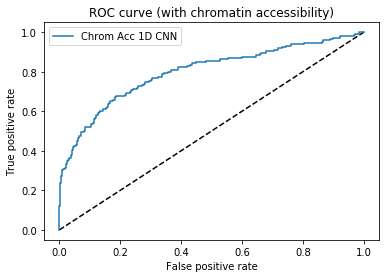

In [42]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Chrom Acc 1D CNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (with chromatin accessibility)')
plt.legend(loc='best')
plt.show()

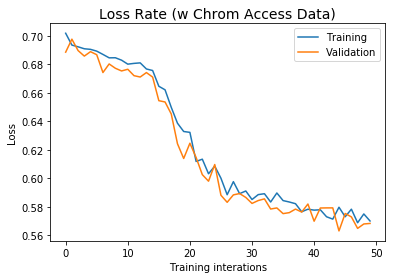

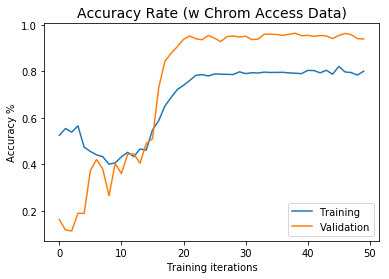

In [43]:
plt.plot(ch_hist.history['loss'])
plt.plot(ch_hist.history['val_loss'])
plt.title('Loss Rate (w Chrom Access Data)', size=14)
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(ch_hist.history['acc'])
plt.plot(ch_hist.history['val_acc'])
plt.title('Accuracy Rate (w Chrom Access Data)', size=14)
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


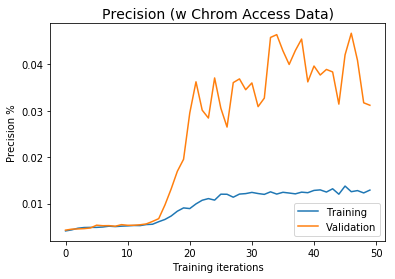

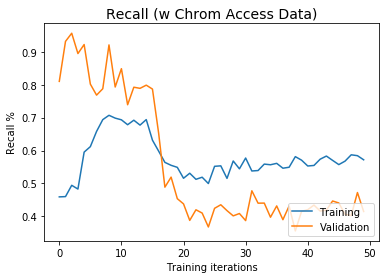

In [44]:
plt.plot(ch_hist.history['precision'])
plt.plot(ch_hist.history['val_precision'])
plt.title('Precision (w Chrom Access Data)', size=14)
plt.ylabel('Precision %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()

plt.plot(ch_hist.history['recall'])
plt.plot(ch_hist.history['val_recall'])
plt.title('Recall (w Chrom Access Data)', size=14)
plt.ylabel('Recall %')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


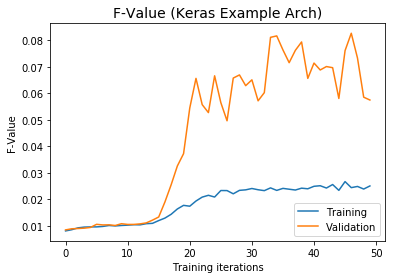

In [45]:
plt.plot(ch_hist.history['fvalue'])
plt.plot(ch_hist.history['val_fvalue'])
plt.title('F-Value (Keras Example Arch)', size=14)
plt.ylabel('F-Value')
plt.xlabel('Training iterations')
plt.legend(['Training','Validation'], loc='lower right')
plt.show()


In [46]:
# True values: y_test
# Pred values: y_chmodel
ch_cm = confusion_matrix(y_test, np.round(y_chmodel))
print(ch_cm)

[[32434  1948]
 [   83    63]]


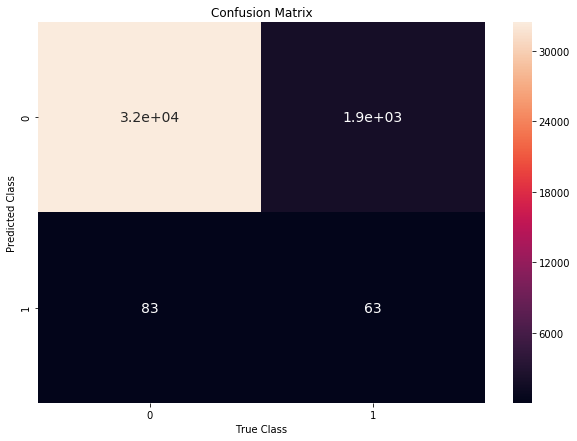

In [47]:
plt.figure(figsize = (10,7))
sns.heatmap(ch_cm, annot=True,annot_kws={"size": 14})
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix")
plt.show()

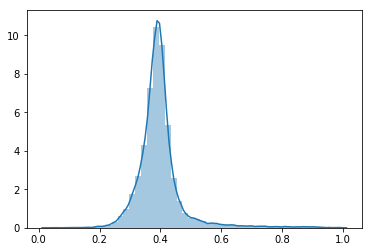

In [48]:
sns.distplot(y_chmodel)

In [49]:
print(np.max(y_chmodel))

0.9956943


In [0]:
features = 4
seq_length = 101
convolution_window = 32
n_filters = 64

# The following creates a model using the Keras functional API
# (instead of using Sequential() and adding layers one at a time)

# Sequence portion of the neural net
sequence_input = Input(shape=(seq_length,features))


# Layers for sequential data
# 
# Layer 1
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', kernel_initializer='normal', padding='same')(sequence_input)
seq = Dropout(0.5)(seq)

seq = Conv1D(n_filters, convolution_window, 
           activation='relu', kernel_initializer='normal', padding='same')(seq)
seq = Dropout(0.5)(seq)

seq = Conv1D(n_filters, convolution_window, 
           activation='relu', kernel_initializer='normal', padding='same')(seq)
seq = Dropout(0.5)(seq)

seq = Flatten()(seq)
seq = keras.Model(inputs=sequence_input, outputs=seq)
chromatin_input = Input(shape=(1,))
fin = keras.layers.concatenate([seq.output,chromatin_input])

# (add a kernel initializer)
fin = Dense(1, kernel_initializer='normal', activation='sigmoid')(fin)

chromatin_model2 = keras.Model(inputs=[seq.input,chromatin_input], outputs=fin)

# Now compile the model
chromatin_model2.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        sample_weight_mode=None,
                        metrics=['accuracy',
                                 precision,
                                 recall,
                                 fvalue])